In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

### Parameters for all Simulations

In [2]:
# functional parameters 
function affect!(integrator) # jump process
      n = rand(1:integrator.p.N)
      n2 = rand(1:integrator.p.N)
      integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
rate(u,p,t) = p.β*p.N # jump rate


# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility, 
    affect! = affect!, # jump process 
    rate = rate)

#3 (generic function with 2 methods)

### Generator Functions for Problem Objects

In [3]:
function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob(p);
    function write_moments(sol, i) 
        resize!(sol.t, 0); resize!(sol.u, 0); append!(sol.t, sol.prob.p.t); append!(sol.u, sol.prob.p.moments)
        return (sol, false)
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end
    
p = params();

### Ensemble Aggregates

Run several simulations, and track the mean of their moments over time.

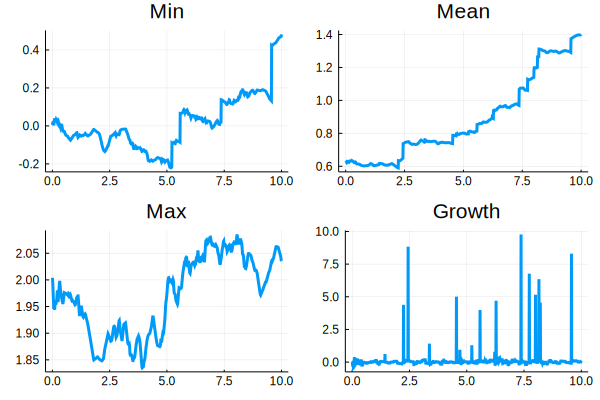

In [4]:
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)

p1 = plot(summ, idxs = [1], error_style = :none, title = "Min")
p2 = plot(summ, idxs = [2], error_style = :none, title = "Mean")
p3 = plot(summ, idxs = [3], error_style = :none, title = "Max")
p4 = plot(summ, idxs = [4], error_style = :none, title = "Growth")

plot(p1, p2, p3, p4)

### Ensemble Trajectories

Run several ensembles, and track the means of the _n_th particle's position over time.

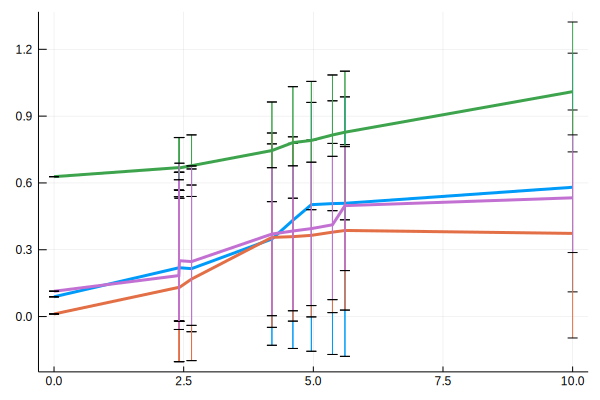

In [7]:
p = params(N = 4, trajectories = 10)
ensemble_prob = EnsembleProblem(generate_jump_prob(p)) # no callback structure, since we care about positions and not moments
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, save_everystep = false)
summ = EnsembleSummary(sim) # aggregates particle positions across simulations
plot(summ, error_style = :bars)

### Single Simulation

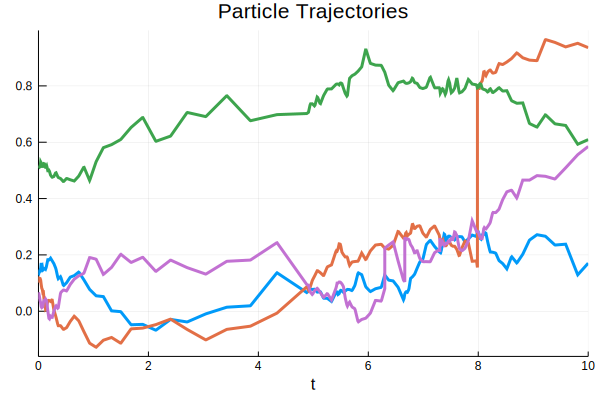

In [6]:
p_single = params(N = 4)
jump_prob = generate_jump_prob(p_single)
sol = solve(jump_prob, p.jump_algorithm, saveat = p.t)
plot(sol, legend = false, title = "Particle Trajectories")